In [1]:
#run in terminal:
#conda init
#(close and then open new terminal)
#conda create -n compass python=3.8
#conda activate compass
#pip install immuno-compass --no-deps
#pip install ipykernel jupyter
#python -m ipykernel install --user --name compass --display-name "Python (COMPASS)"

In [3]:
import sys


!"{sys.executable}" -m pip uninstall -y wandb immuno-compass
!"{sys.executable}" -m pip install \
    numpy \
    pandas \
    scipy \
    scikit-learn \
    tqdm \
    umap-learn \
    seaborn \
    matplotlib \
    einops \
    openpyxl \
    gdown    \
    plotly \
    colorcet
    

!"{sys.executable}" -m pip install torch torchvision torchaudio
!"{sys.executable}" -m pip install 'wandb==0.16.6'
!"{sys.executable}" -m pip install immuno-compass --no-deps

import numpy, torch, compass
print("NumPy:", numpy.__version__)
print("Torch:", torch.__version__)
print("COMPASS:", compass.__version__)

Found existing installation: wandb 0.16.6
Uninstalling wandb-0.16.6:
  Successfully uninstalled wandb-0.16.6
Found existing installation: immuno-compass 2.2
Uninstalling immuno-compass-2.2:
  Successfully uninstalled immuno-compass-2.2
  Using cached wandb-0.16.6-py3-none-any.whl.metadata (10 kB)
Using cached wandb-0.16.6-py3-none-any.whl (2.2 MB)
  Using cached immuno_compass-2.2-py3-none-any.whl.metadata (10 kB)
Using cached immuno_compass-2.2-py3-none-any.whl (4.3 MB)


/home/taiqili/.conda/envs/compass/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NumPy: 1.24.4
Torch: 2.4.1+cu121
COMPASS: 2.2


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
#df_rna_LGG = pd.read_csv("TCGA_GBMLGG/TCGA.LGG.sampleMap_HiSeqV2", sep="\t", index_col=0)
#df_rna_GBM = pd.read_csv("TCGA_GBMLGG/TCGA.GBM.sampleMap_HiSeqV2", sep="\t", index_col=0)

In [8]:
# the dataset of the RNA expression from the Pathomic Fusion peper only inlude the 
# about 150 top differentially expressed genes, COMPASS require the whole geneset for the GBM and 
# LGG dataset so download the preprocessed whole geneset
# could be found here: https://xenabrowser.net/datapages/?dataset=TCGA.GBM.sampleMap%2FHiSeqV2&host=https%3A%2F%2Ftcga.xenahubs.net&removeHub=http%3A%2F%2F127.0.0.1%3A7222
url_LGG = "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/TCGA.LGG.sampleMap/HiSeqV2.gz"
df_rna_LGG = pd.read_csv(url_LGG, sep="\t", index_col=0).T

url_GBM = "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/TCGA.GBM.sampleMap/HiSeqV2.gz"
df_rna_GBM = pd.read_csv(url_GBM, sep="\t", index_col=0).T

print(df_rna_GBM.shape)


(172, 20530)


In [9]:
print(df_rna_LGG.shape)

(530, 20530)


#### transform to the COMPASS require input format 

In [2]:
#reference: https://www.immuno-compass.com/help/index.html#pipeline

In [10]:
df_rna_LGG['cancer_type'] = 'LGG'
df_rna_GBM['cancer_type'] = 'GBM'

In [11]:
df_cancer_type_LGG = pd.DataFrame([], index = df_rna_LGG.index)
df_cancer_type_LGG['cancer_type'] = 'LGG'
df_cancer_type_LGG.head()

df_cancer_type_GBM = pd.DataFrame([], index = df_rna_GBM.index)
df_cancer_type_GBM['cancer_type'] = 'GBM'
df_cancer_type_GBM.head()

,cancer_type
TCGA-27-1832-01,GBM
TCGA-27-1831-01,GBM
TCGA-28-5216-01,GBM
TCGA-16-0846-01,GBM
TCGA-28-5218-01,GBM


In [12]:
import json
cancer_code_map = pd.read_json('https://www.immuno-compass.com/download/other/cancer_code.json',
                               orient= 'index')[0]
df_cancer_type_LGG['cancer_type'] = df_cancer_type_LGG['cancer_type'].map(cancer_code_map)
df_cancer_type_LGG.head()

df_cancer_type_GBM['cancer_type'] = df_cancer_type_GBM['cancer_type'].map(cancer_code_map)
df_cancer_type_GBM.head()

,cancer_type
TCGA-27-1832-01,8
TCGA-27-1831-01,8
TCGA-28-5216-01,8
TCGA-16-0846-01,8
TCGA-28-5218-01,8


In [13]:
GBMLGG_type = pd.concat([df_cancer_type_LGG,df_cancer_type_GBM], axis = 0)
GBMLGG_type

,cancer_type
TCGA-E1-5319-01,14
TCGA-HT-7693-01,14
TCGA-CS-6665-01,14
TCGA-S9-A7J2-01,14
TCGA-FG-A6J3-01,14
...,...
TCGA-06-0210-01,8
TCGA-06-0210-02,8
TCGA-02-0047-01,8
TCGA-06-0750-01,8


In [14]:
gene_map = pd.read_csv('https://www.immuno-compass.com/download/other/compass_gene_map.csv')
gene_map.head()

,ensid,gene_name,ensid_v36,gene_type,gene_supertype,entrezgene
0,ENSG00000121410,A1BG,ENSG00000121410.12,protein_coding,protein_coding,1.0
1,ENSG00000148584,A1CF,ENSG00000148584.15,protein_coding,protein_coding,29974.0
2,ENSG00000175899,A2M,ENSG00000175899.15,protein_coding,protein_coding,2.0
3,ENSG00000166535,A2ML1,ENSG00000166535.20,protein_coding,protein_coding,144568.0
4,ENSG00000128274,A4GALT,ENSG00000128274.17,protein_coding,protein_coding,53947.0


In [15]:
compass_gene = gene_map['gene_name']

In [16]:
LGG_gene = df_rna_LGG.columns
filter_LGG = LGG_gene.intersection(compass_gene)

In [17]:
filter_LGG

Index(['ARHGEF10L', 'HIF3A', 'RNF17', 'RNF10', 'RNF11', 'RNF13', 'REM1',
       'RTN4RL2', 'FGFR1OP2', 'TSKS',
       ...
       'SELE', 'SLC7A10', 'TULP2', 'NPY5R', 'GNGT2', 'GNGT1', 'TULP3', 'BCL6B',
       'GSTK1', 'SELP'],
      dtype='object', name='sample', length=14639)

In [18]:
df_rna_LGG_compass = pd.DataFrame(index = df_rna_LGG.index, columns = compass_gene, dtype = float)

In [19]:
df_rna_LGG_compass[filter_LGG]= df_rna_LGG[filter_LGG.to_numpy()]
df_rna_LGG_compass = df_rna_LGG_compass.fillna(0.0)
df_rna_LGG_compass

gene_name,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,AADAT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
TCGA-E1-5319-01,5.6798,0.000,13.2209,6.8412,6.6866,0.0000,9.4316,8.3869,0.0000,7.7131,...,6.4501,6.0631,6.9436,8.9813,10.4000,0.0000,10.0977,10.5724,10.4658,8.5779
TCGA-HT-7693-01,7.1947,0.000,13.6607,7.0792,5.9884,0.4540,9.7909,8.3357,0.0000,8.1434,...,6.9764,5.7114,6.2630,8.5228,10.5289,0.4540,10.5454,10.9572,11.0220,9.4471
TCGA-CS-6665-01,6.5517,0.421,15.1145,3.4813,7.2398,0.4210,9.4199,7.6337,0.0000,8.1583,...,7.5758,8.4627,5.6770,8.7744,9.9168,0.4210,10.5202,11.3799,10.6887,9.9319
TCGA-S9-A7J2-01,6.8300,0.000,12.9026,6.0559,6.5244,0.4657,9.8901,7.7284,0.0000,8.2972,...,6.6247,7.2101,7.0616,9.2240,10.6915,0.0000,9.9788,11.4448,11.0126,8.2884
TCGA-FG-A6J3-01,8.1842,0.000,16.1838,2.8864,7.8261,0.0000,9.2426,8.3009,0.0000,6.5986,...,7.0195,7.9369,3.8928,7.3812,9.6662,1.3777,9.2962,11.9793,9.8763,8.5407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-HT-A74O-01,7.7478,0.000,14.0447,4.8195,6.6901,0.5635,9.9825,8.5804,0.0000,7.7991,...,7.3606,7.5824,5.2031,7.7423,9.8408,0.5635,9.3097,12.5306,10.1623,8.7324
TCGA-DU-A76O-01,6.7946,0.000,13.8991,6.2998,6.2743,0.9415,9.6438,8.2860,0.0000,8.6768,...,6.9200,8.0683,5.8250,8.0976,9.8239,0.5462,9.7548,11.5781,10.6392,8.3646
TCGA-DU-A5TW-01,7.0207,0.000,13.0760,6.2346,5.9342,0.5284,10.0776,8.2685,0.0000,8.6420,...,7.3350,7.9005,4.9160,8.5064,10.1718,0.0000,10.1189,11.7765,10.7281,9.4662
TCGA-HT-7857-01,6.4474,0.000,15.6192,1.0293,7.9485,0.0000,9.1032,8.1328,1.9169,8.2377,...,7.9936,7.7857,5.8983,8.2327,10.1137,0.4297,9.9416,13.1136,10.8092,9.2527


In [20]:
df_rna_GBM

sample,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,RTN4RL2,...,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS,cancer_type
TCGA-27-1832-01,9.8929,9.2511,0.0,11.9661,10.8284,11.2220,13.0658,1.8913,0.0000,4.2528,...,4.7890,6.3144,0.0,9.2901,13.3932,6.8431,11.9599,2.9587,10.1312,GBM
TCGA-27-1831-01,8.5115,2.3579,0.0,10.2652,12.3519,12.7531,12.9097,4.2597,0.0000,1.7973,...,3.8282,6.3260,0.0,7.8635,9.9241,6.5070,12.7814,3.4467,11.2738,GBM
TCGA-28-5216-01,10.4760,7.6115,0.0,11.7539,11.7062,11.4857,12.9442,6.2670,0.0000,6.8413,...,5.3732,5.3732,0.0,9.3183,11.6749,7.2965,10.3013,2.8632,10.1483,GBM
TCGA-16-0846-01,11.1505,7.5040,0.0,11.6295,11.4582,11.3496,13.3215,5.6188,0.0000,6.5432,...,1.9506,6.1826,0.0,8.1119,11.4936,7.0656,11.1088,1.1017,9.6133,GBM
TCGA-28-5218-01,8.9427,8.1849,0.0,11.8359,10.8263,9.9637,13.3806,8.8829,0.7176,7.9718,...,1.1947,5.7507,0.0,10.1496,14.4017,8.5474,11.7222,5.2129,10.4957,GBM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-06-0210-01,9.6700,9.1845,0.0,11.9743,11.5663,11.4246,12.7685,1.9650,0.5695,5.9426,...,1.7740,5.3119,0.0,9.6879,12.5057,5.7869,10.8178,0.5695,10.3326,GBM
TCGA-06-0210-02,11.0339,8.7847,0.0,11.7870,11.1721,11.4031,13.3368,5.1292,0.5711,5.8414,...,1.5571,6.2805,0.0,9.2935,12.3474,8.6603,10.9528,2.2885,9.5431,GBM
TCGA-02-0047-01,10.8850,7.2025,0.0,11.4257,11.4626,11.7846,13.2226,2.7075,0.0000,7.6271,...,5.4803,5.6837,0.0,8.8536,11.5592,7.3565,10.0220,1.1566,9.5989,GBM
TCGA-06-0750-01,10.3499,7.4013,0.0,11.7639,11.2690,11.1799,13.3684,4.5466,0.0000,6.9641,...,1.8984,5.2310,0.0,9.4227,12.7398,8.1142,12.0160,3.9756,10.4257,GBM


In [21]:
GBM_gene = df_rna_GBM.columns
filter_GBM = GBM_gene.intersection(compass_gene)
filter_GBM

Index(['ARHGEF10L', 'HIF3A', 'RNF17', 'RNF10', 'RNF11', 'RNF13', 'REM1',
       'RTN4RL2', 'FGFR1OP2', 'TSKS',
       ...
       'SELE', 'SLC7A10', 'TULP2', 'NPY5R', 'GNGT2', 'GNGT1', 'TULP3', 'BCL6B',
       'GSTK1', 'SELP'],
      dtype='object', name='sample', length=14639)

In [22]:
df_rna_GBM_compass = pd.DataFrame(index = df_rna_GBM.index, columns = compass_gene, dtype = float)

In [23]:
df_rna_GBM_compass[filter_GBM]= df_rna_GBM[filter_GBM.to_numpy()]
df_rna_GBM_compass = df_rna_GBM_compass.fillna(0.0)
df_rna_GBM_compass

gene_name,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,AADAT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
TCGA-27-1832-01,6.4522,0.0000,14.9590,8.9672,8.1321,2.0570,9.8148,8.9711,0.0000,6.9887,...,8.7618,9.1640,5.0668,8.2841,10.0444,0.9284,9.5053,12.4902,9.7535,9.1388
TCGA-27-1831-01,8.5691,0.0000,13.8078,6.5070,5.4834,0.8681,9.0565,8.5908,1.7973,6.2653,...,8.0273,8.5784,4.3205,8.0000,9.1807,5.0879,11.1461,11.9783,8.1247,9.8107
TCGA-28-5216-01,7.7439,0.0000,14.9421,3.6038,6.1301,0.0000,9.6379,8.8581,0.0000,7.8083,...,8.2393,8.6733,5.6182,8.4528,10.5524,1.2598,10.1106,12.6776,10.0719,9.6328
TCGA-16-0846-01,7.4614,0.0000,14.0274,7.4001,7.7770,0.0000,9.5802,8.9629,0.6536,7.3804,...,7.8870,8.6413,5.2356,8.3331,9.7664,0.0000,9.8494,11.8764,9.4945,9.2422
TCGA-28-5218-01,5.3087,0.0000,15.5009,1.1947,9.9029,1.5525,9.4845,9.7043,1.5525,8.5842,...,9.1157,8.7027,6.1416,8.7336,9.1919,0.7176,9.7439,13.5075,10.7229,8.9198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-06-0210-01,7.7696,0.0000,15.4648,3.4169,4.5401,1.2940,9.6803,8.9334,0.0000,8.0328,...,7.8341,7.7831,5.7995,8.5079,10.2541,0.0000,10.2147,13.9414,10.3805,9.4411
TCGA-06-0210-02,6.8891,0.5711,15.4764,4.7669,6.4899,0.9791,9.5165,8.4817,0.5711,7.7624,...,7.9508,8.7047,6.1386,8.6412,10.1148,0.0000,10.0744,13.3374,10.6001,9.2527
TCGA-02-0047-01,6.9774,0.0000,15.0538,5.3985,5.2197,1.1566,8.8689,8.9155,0.0000,7.8738,...,8.0291,8.6633,6.0477,8.4818,10.1161,0.6912,10.2386,11.9177,10.4492,9.2398
TCGA-06-0750-01,8.1588,0.0000,14.3134,6.8798,7.1858,1.0644,9.7661,8.9554,0.6282,7.4695,...,8.1246,7.6172,5.0528,7.9928,10.0222,1.3988,9.5310,13.3493,9.8899,8.9681


In [24]:
nan_cols = df_rna_GBM_compass.columns[df_rna_GBM_compass.isna().any()]
print("Columns with NaNs:", nan_cols.tolist())

Columns with NaNs: []


In [25]:
GBMLGG_df = pd.concat([df_rna_GBM_compass,df_rna_LGG_compass], axis = 0)

In [26]:
GBMLGG_df

gene_name,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,AADAT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
TCGA-27-1832-01,6.4522,0.0,14.9590,8.9672,8.1321,2.0570,9.8148,8.9711,0.0000,6.9887,...,8.7618,9.1640,5.0668,8.2841,10.0444,0.9284,9.5053,12.4902,9.7535,9.1388
TCGA-27-1831-01,8.5691,0.0,13.8078,6.5070,5.4834,0.8681,9.0565,8.5908,1.7973,6.2653,...,8.0273,8.5784,4.3205,8.0000,9.1807,5.0879,11.1461,11.9783,8.1247,9.8107
TCGA-28-5216-01,7.7439,0.0,14.9421,3.6038,6.1301,0.0000,9.6379,8.8581,0.0000,7.8083,...,8.2393,8.6733,5.6182,8.4528,10.5524,1.2598,10.1106,12.6776,10.0719,9.6328
TCGA-16-0846-01,7.4614,0.0,14.0274,7.4001,7.7770,0.0000,9.5802,8.9629,0.6536,7.3804,...,7.8870,8.6413,5.2356,8.3331,9.7664,0.0000,9.8494,11.8764,9.4945,9.2422
TCGA-28-5218-01,5.3087,0.0,15.5009,1.1947,9.9029,1.5525,9.4845,9.7043,1.5525,8.5842,...,9.1157,8.7027,6.1416,8.7336,9.1919,0.7176,9.7439,13.5075,10.7229,8.9198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-HT-A74O-01,7.7478,0.0,14.0447,4.8195,6.6901,0.5635,9.9825,8.5804,0.0000,7.7991,...,7.3606,7.5824,5.2031,7.7423,9.8408,0.5635,9.3097,12.5306,10.1623,8.7324
TCGA-DU-A76O-01,6.7946,0.0,13.8991,6.2998,6.2743,0.9415,9.6438,8.2860,0.0000,8.6768,...,6.9200,8.0683,5.8250,8.0976,9.8239,0.5462,9.7548,11.5781,10.6392,8.3646
TCGA-DU-A5TW-01,7.0207,0.0,13.0760,6.2346,5.9342,0.5284,10.0776,8.2685,0.0000,8.6420,...,7.3350,7.9005,4.9160,8.5064,10.1718,0.0000,10.1189,11.7765,10.7281,9.4662
TCGA-HT-7857-01,6.4474,0.0,15.6192,1.0293,7.9485,0.0000,9.1032,8.1328,1.9169,8.2377,...,7.9936,7.7857,5.8983,8.2327,10.1137,0.4297,9.9416,13.1136,10.8092,9.2527


In [27]:
GBMLGG_df = pd.merge(GBMLGG_type,GBMLGG_df, left_index=True, right_index=True)


In [28]:
GBMLGG_df = GBMLGG_df.rename(columns={'cancer_type': 'cancer_code'})

In [29]:
GBMLGG_df

,cancer_code,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
TCGA-E1-5319-01,14,5.6798,0.0000,13.2209,6.8412,6.6866,0.0000,9.4316,8.3869,0.0000,...,6.4501,6.0631,6.9436,8.9813,10.4000,0.0000,10.0977,10.5724,10.4658,8.5779
TCGA-HT-7693-01,14,7.1947,0.0000,13.6607,7.0792,5.9884,0.4540,9.7909,8.3357,0.0000,...,6.9764,5.7114,6.2630,8.5228,10.5289,0.4540,10.5454,10.9572,11.0220,9.4471
TCGA-CS-6665-01,14,6.5517,0.4210,15.1145,3.4813,7.2398,0.4210,9.4199,7.6337,0.0000,...,7.5758,8.4627,5.6770,8.7744,9.9168,0.4210,10.5202,11.3799,10.6887,9.9319
TCGA-S9-A7J2-01,14,6.8300,0.0000,12.9026,6.0559,6.5244,0.4657,9.8901,7.7284,0.0000,...,6.6247,7.2101,7.0616,9.2240,10.6915,0.0000,9.9788,11.4448,11.0126,8.2884
TCGA-FG-A6J3-01,14,8.1842,0.0000,16.1838,2.8864,7.8261,0.0000,9.2426,8.3009,0.0000,...,7.0195,7.9369,3.8928,7.3812,9.6662,1.3777,9.2962,11.9793,9.8763,8.5407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-06-0210-01,8,7.7696,0.0000,15.4648,3.4169,4.5401,1.2940,9.6803,8.9334,0.0000,...,7.8341,7.7831,5.7995,8.5079,10.2541,0.0000,10.2147,13.9414,10.3805,9.4411
TCGA-06-0210-02,8,6.8891,0.5711,15.4764,4.7669,6.4899,0.9791,9.5165,8.4817,0.5711,...,7.9508,8.7047,6.1386,8.6412,10.1148,0.0000,10.0744,13.3374,10.6001,9.2527
TCGA-02-0047-01,8,6.9774,0.0000,15.0538,5.3985,5.2197,1.1566,8.8689,8.9155,0.0000,...,8.0291,8.6633,6.0477,8.4818,10.1161,0.6912,10.2386,11.9177,10.4492,9.2398
TCGA-06-0750-01,8,8.1588,0.0000,14.3134,6.8798,7.1858,1.0644,9.7661,8.9554,0.6282,...,8.1246,7.6172,5.0528,7.9928,10.0222,1.3988,9.5310,13.3493,9.8899,8.9681


In [30]:
GBMLGG_df.to_csv('GBMLGG_df_ver2.csv')

#### concepts embedding for the bulk seq 

In [31]:
from compass import PreTrainer, FineTuner, loadcompass
from compass.tokenizer import CONCEPT, CONCEPT_palette
from compass.tokenizer import CANCER_CODE

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap, MDS, LocallyLinearEmbedding
import os
sns.set(style = 'white', font_scale=1.5)
%matplotlib inline

In [38]:
# copy from https://www.immuno-compass.com/help/index.html#pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)

from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap, MDS, LocallyLinearEmbedding

import colorcet as cc
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle


def plot_colortable(colors, *, ncols=4, sort_colors=True, anote = True, margin = 12, swatch_width = 48):

    cell_width = 230
    cell_height = 30
    swatch_width = swatch_width
    margin = margin

    # Sort colors by hue, saturation, value and name.
    if sort_colors is True:
        names = sorted(
            colors, key=lambda c: tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(c))))
    else:
        names = list(colors)

    n = len(names)
    nrows = math.ceil(n / ncols)

    width = cell_width * ncols + 2 * margin
    height = cell_height * nrows + 2 * margin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-margin)/height)
    ax.set_xlim(0, cell_width * ncols)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=colors[name], edgecolor='0.7')
        )

        if anote:
            ax.text(swatch_start_x, y, colors[name], fontsize=10,
                    horizontalalignment='left', color = 'white',
                    verticalalignment='center')

    return fig

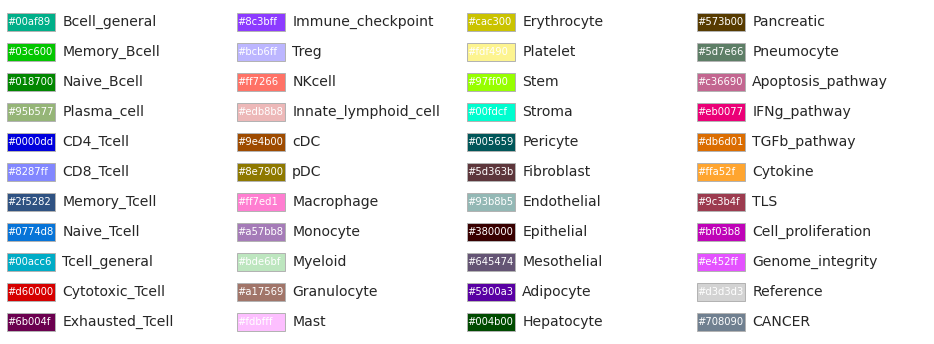

In [40]:
#copy from https://www.immuno-compass.com/help/index.html#pipeline
fig = plot_colortable(CONCEPT_palette, ncols=4, sort_colors = False)

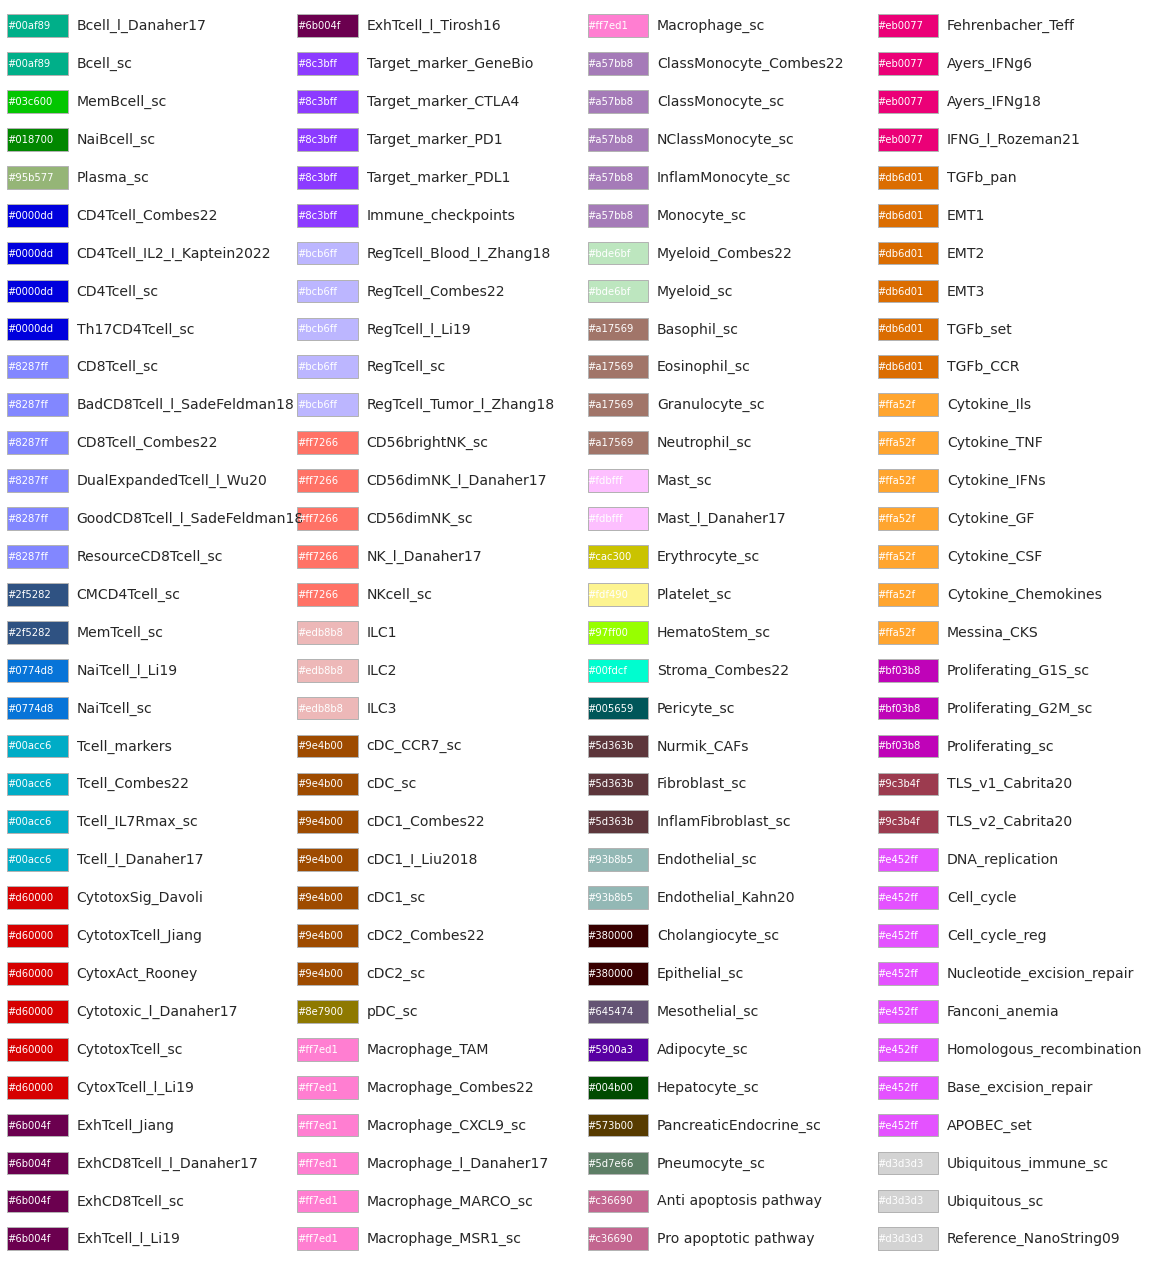

In [41]:
#copy from https://www.immuno-compass.com/help/index.html#pipeline
GENESET_palette = CONCEPT.BroadCelltypePathway.map(CONCEPT_palette).to_dict()
fig = plot_colortable(GENESET_palette, sort_colors = False, ncols=4,  margin = 150)
fig.tight_layout()

In [32]:
#there are a lot of model we could choose, which can be donwload here:
#https://www.immuno-compass.com/download/
#i choose PT Model:Base model pre-trained on pan-cancer TCGA transcriptomic 
# datasets (33 cancer types), used for concept feature extraction.
pretrainer = loadcompass('pretrainer.pt', map_location='cpu')


In [33]:
print("Shape:", GBMLGG_df.shape)
print("First 5 cols:", GBMLGG_df.columns[:5].tolist())
print("Last 5 cols:", GBMLGG_df.columns[-5:].tolist())
print(GBMLGG_df.dtypes.head())
print("Any NaN?", GBMLGG_df.isna().any().any())

Shape: (702, 15673)
First 5 cols: ['cancer_code', 'A1BG', 'A1CF', 'A2M', 'A2ML1']
Last 5 cols: ['ZYG11A', 'ZYG11B', 'ZYX', 'ZZEF1', 'ZZZ3']
cancer_code      int64
A1BG           float64
A1CF           float64
A2M            float64
A2ML1          float64
dtype: object
Any NaN? False


In [34]:
#Extract Concept Feature
dfg, dfc = pretrainer.project(
    GBMLGG_df,
    batch_size=128,     
    num_workers=0        
)

100%|##########| 6/6 [01:09<00:00, 11.64s/it]


In [35]:
#this one stuck
#dfg, dfc = pretrainer.project(GBMLGG_df,  batch_size= 512)

In [39]:
dfc.index[:10]

Index(['TCGA-E1-5319-01$$Bcell_general', 'TCGA-E1-5319-01$$Memory_Bcell',
       'TCGA-E1-5319-01$$Naive_Bcell', 'TCGA-E1-5319-01$$Plasma_cell',
       'TCGA-E1-5319-01$$CD4_Tcell', 'TCGA-E1-5319-01$$CD8_Tcell',
       'TCGA-E1-5319-01$$Memory_Tcell', 'TCGA-E1-5319-01$$Naive_Tcell',
       'TCGA-E1-5319-01$$Tcell_general', 'TCGA-E1-5319-01$$Cytotoxic_Tcell'],
      dtype='object')

In [42]:
#copy from https://www.immuno-compass.com/help/index.html#pipeline
df_geneset_feat = pd.DataFrame(index=dfg.index)
df_geneset_feat['bcr_patient_barcode'] = dfg.index.map(lambda x:x.split('$$')[0])
df_geneset_feat['feature_name'] = dfg.index.map(lambda x:x.split('$$')[1])
df_geneset_feat = df_geneset_feat.join(dfg)
df_geneset_feat = df_geneset_feat.sort_values(['feature_name', 'bcr_patient_barcode'])

In [43]:
#copy from https://www.immuno-compass.com/help/index.html#pipeline
df_celltype_feat = pd.DataFrame(index=dfc.index)
df_celltype_feat['bcr_patient_barcode'] = dfc.index.map(lambda x:x.split('$$')[0])
df_celltype_feat['feature_name'] = dfc.index.map(lambda x:x.split('$$')[1])
df_celltype_feat = df_celltype_feat.join(dfc)
df_celltype_feat = df_celltype_feat.sort_values(['feature_name', 'bcr_patient_barcode'])

In [44]:
#copy from https://www.immuno-compass.com/help/index.html#pipeline
dfc = df_celltype_feat
data = dfc[dfc.columns[-32:]]
mp = UMAP(n_components = 2, n_neighbors= 100, n_epochs = 500,  
          min_dist=0.8, random_state = 42,   verbose=1 ) #
umap2d = mp.fit_transform(data)
df_umap2d  = pd.DataFrame(umap2d, index=dfc.index, columns = ['UMAP1', 'UMAP2'])
dfp = dfc[['bcr_patient_barcode', 'feature_name']].join(df_umap2d)

UMAP(min_dist=0.8, n_epochs=500, n_jobs=1, n_neighbors=100, random_state=42, verbose=1)
Thu Dec  4 00:21:19 2025 Construct fuzzy simplicial set
Thu Dec  4 00:21:19 2025 Finding Nearest Neighbors
Thu Dec  4 00:21:19 2025 Building RP forest with 14 trees
Thu Dec  4 00:21:25 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	Stopping threshold met -- exiting after 2 iterations
Thu Dec  4 00:22:19 2025 Finished Nearest Neighbor Search
Thu Dec  4 00:22:25 2025 Construct embedding


Epochs completed:   0%|            1/500 [00:01]

	completed  0  /  500 epochs


Epochs completed:  10%| █          51/500 [00:19]

	completed  50  /  500 epochs


Epochs completed:  20%| ██         101/500 [00:40]

	completed  100  /  500 epochs


Epochs completed:  30%| ███        152/500 [01:00]

	completed  150  /  500 epochs


Epochs completed:  40%| ████       202/500 [01:19]

	completed  200  /  500 epochs


Epochs completed:  50%| █████      252/500 [01:39]

	completed  250  /  500 epochs


Epochs completed:  60%| ██████     302/500 [01:59]

	completed  300  /  500 epochs


Epochs completed:  70%| ███████    351/500 [02:18]

	completed  350  /  500 epochs


Epochs completed:  80%| ████████   402/500 [02:38]

	completed  400  /  500 epochs


Epochs completed:  90%| █████████  452/500 [02:56]

	completed  450  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [03:14]

Thu Dec  4 00:25:46 2025 Finished embedding


(-24.596402645111084,
 30.587924480438232,
 -24.445626640319823,
 29.607705497741698)

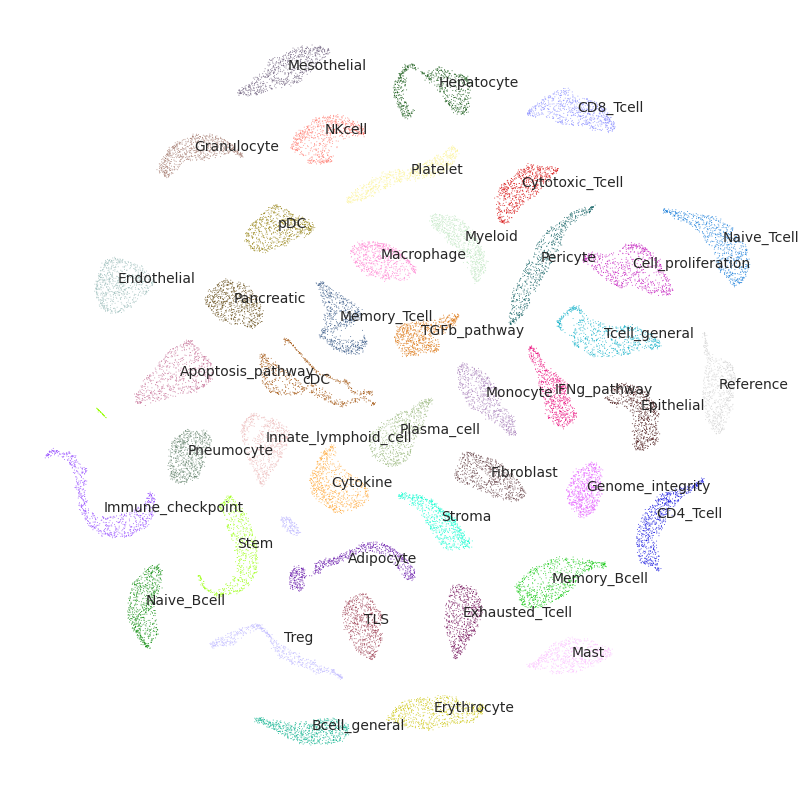

In [45]:
#copy from https://www.immuno-compass.com/help/index.html#pipeline
hue_order = CONCEPT_palette.keys()
hue_color = CONCEPT_palette.values()

fig, ax = plt.subplots(figsize=(10, 10))

x = 'UMAP1'
y = 'UMAP2'
hue = 'feature_name'

sns.scatterplot(data = dfp, x = x, y = y, hue = hue,  alpha = 0.8,
                linewidth=0.0, hue_order = hue_order, palette=hue_color, s = 0.5, 
                 ax=ax, legend=False)

mean = dfp.groupby(hue)[[x,y]].median()
for name in mean.index:
    s = mean.loc[name]
    ax.text(s[x], s[y], name,  fontdict={'fontsize':10})

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
ax.set_xlabel('')
ax.set_ylabel('')

plt.axis('off')

In [46]:
#copy from https://www.immuno-compass.com/help/index.html#pipeline
dfc = df_geneset_feat
data = dfc[dfc.columns[-32:]]
mp = UMAP(n_components = 2, n_neighbors=200,  min_dist=0.5, random_state = 42,   verbose=1 ) #
umap2d = mp.fit_transform(data)
df_umap2d  = pd.DataFrame(umap2d, index=data.index, columns = ['UMAP1', 'UMAP2'])
dfp = dfc[['bcr_patient_barcode', 'feature_name']].join(df_umap2d)

UMAP(min_dist=0.5, n_jobs=1, n_neighbors=200, random_state=42, verbose=1)
Thu Dec  4 00:26:27 2025 Construct fuzzy simplicial set
Thu Dec  4 00:26:27 2025 Finding Nearest Neighbors
Thu Dec  4 00:26:27 2025 Building RP forest with 20 trees
Thu Dec  4 00:26:27 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
Thu Dec  4 00:29:13 2025 Finished Nearest Neighbor Search
Thu Dec  4 00:29:27 2025 Construct embedding


Epochs completed:   1%|            2/200 [00:00]

	completed  0  /  200 epochs


Epochs completed:  11%| █          22/200 [00:22]

	completed  20  /  200 epochs


Epochs completed:  20%| ██         41/200 [00:46]

	completed  40  /  200 epochs


Epochs completed:  30%| ███        61/200 [01:11]

	completed  60  /  200 epochs


Epochs completed:  40%| ████       81/200 [01:35]

	completed  80  /  200 epochs


Epochs completed:  50%| █████      101/200 [02:01]

	completed  100  /  200 epochs


Epochs completed:  61%| ██████     122/200 [02:29]

	completed  120  /  200 epochs


Epochs completed:  70%| ███████    141/200 [02:53]

	completed  140  /  200 epochs


Epochs completed:  80%| ████████   161/200 [03:19]

	completed  160  /  200 epochs


Epochs completed:  91%| █████████  182/200 [03:46]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [04:10]

Thu Dec  4 00:34:58 2025 Finished embedding


(-20.28038558959961, 27.74301681518555, -22.4025559425354, 25.30460023880005)

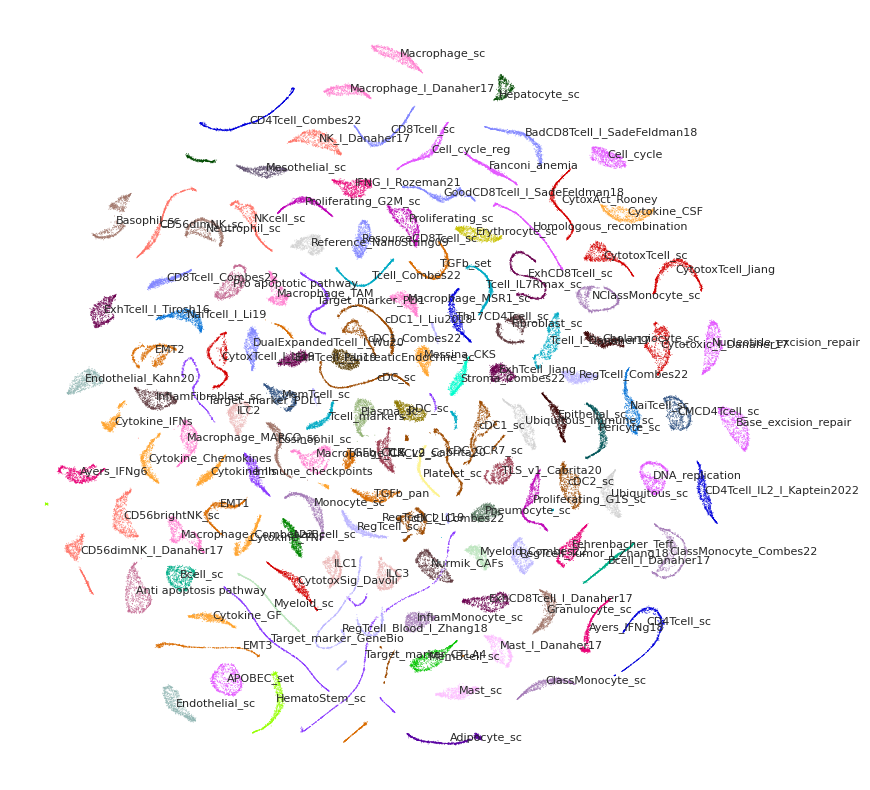

In [47]:
#copy from https://www.immuno-compass.com/help/index.html#pipeline
hue_order = GENESET_palette.keys()
hue_color = GENESET_palette.values()

fig, ax = plt.subplots(figsize=(10, 10))

x = 'UMAP1'
y = 'UMAP2'
hue = 'feature_name'

sns.scatterplot(data = dfp, x = x, y = y, hue = hue,  alpha = 0.8,
                linewidth=0.0, hue_order = hue_order, palette=hue_color, s = 0.5, 
                 ax=ax, legend=False)

mean = dfp.groupby(hue)[[x,y]].median()
for name in mean.index:
    s = mean.loc[name]
    ax.text(s[x], s[y], name,  fontdict={'fontsize':8})

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
ax.set_xlabel('')
ax.set_ylabel('')
plt.axis('off')

In [52]:
df_celltype_feat

,bcr_patient_barcode,feature_name,channel_0,channel_1,channel_2,channel_3,channel_4,channel_5,channel_6,channel_7,...,channel_22,channel_23,channel_24,channel_25,channel_26,channel_27,channel_28,channel_29,channel_30,channel_31
TCGA-02-0047-01$$Adipocyte,TCGA-02-0047-01,Adipocyte,-0.322608,0.102744,-0.352871,0.756024,0.308621,0.241735,0.131078,-0.011974,...,-0.330752,-0.426774,-0.507830,-0.236596,-0.541070,0.055074,0.451272,-0.089528,0.867294,0.380523
TCGA-02-0055-01$$Adipocyte,TCGA-02-0055-01,Adipocyte,-0.294127,0.095272,-0.309944,0.747195,0.323017,0.227294,0.216790,-0.001108,...,-0.325832,-0.507098,-0.586600,-0.175654,-0.689655,0.139071,0.358943,-0.116997,0.886994,0.378754
TCGA-02-2483-01$$Adipocyte,TCGA-02-2483-01,Adipocyte,-0.536393,0.096498,-0.378089,0.674423,0.282359,0.204856,-0.068838,-0.001631,...,-0.356166,-0.480511,-0.330384,-0.300050,-0.084808,0.017497,0.680114,-0.135756,0.908591,0.375145
TCGA-02-2485-01$$Adipocyte,TCGA-02-2485-01,Adipocyte,-0.407149,0.112568,-0.369668,0.726870,0.295057,0.222515,-0.040812,-0.007745,...,-0.341575,-0.423054,-0.404609,-0.255592,-0.303926,0.029679,0.543181,-0.094628,0.881159,0.381783
TCGA-02-2486-01$$Adipocyte,TCGA-02-2486-01,Adipocyte,-0.270806,0.079184,-0.368063,0.791710,0.301120,0.245855,0.189213,-0.001346,...,-0.316674,-0.422241,-0.556678,-0.188579,-0.622423,0.079543,0.400633,-0.080935,0.858670,0.375301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-WY-A85A-01$$pDC,TCGA-WY-A85A-01,pDC,-0.144944,0.428151,0.727058,0.098493,0.134066,0.519669,0.145589,0.229536,...,-0.112629,0.491497,-0.746690,-0.512823,-1.119747,-0.264443,0.181521,-0.610488,0.021983,0.433040
TCGA-WY-A85B-01$$pDC,TCGA-WY-A85B-01,pDC,-0.142554,0.420697,0.730773,0.186960,0.122308,0.532484,0.143183,0.225930,...,-0.105101,0.542988,-0.751022,-0.517277,-1.128513,-0.256975,0.110710,-0.564628,-0.028693,0.437514
TCGA-WY-A85C-01$$pDC,TCGA-WY-A85C-01,pDC,-0.135903,0.409416,0.704714,0.195164,0.115943,0.540792,0.159020,0.242278,...,-0.096578,0.532837,-0.764364,-0.506037,-1.128933,-0.246264,0.111331,-0.562301,-0.012103,0.432156
TCGA-WY-A85D-01$$pDC,TCGA-WY-A85D-01,pDC,-0.148742,0.436059,0.757943,0.136625,0.130601,0.524451,0.144202,0.216815,...,-0.111561,0.507113,-0.744092,-0.521062,-1.120690,-0.271273,0.152008,-0.613500,-0.016672,0.438998


In [59]:
#save the two embedding dataset for fusion steps 
df_celltype_save = df_celltype_feat.set_index(['bcr_patient_barcode','feature_name'])[['channel_0', 'channel_1',
       'channel_2', 'channel_3', 'channel_4', 'channel_5', 'channel_6',
       'channel_7', 'channel_8', 'channel_9', 'channel_10', 'channel_11',
       'channel_12', 'channel_13', 'channel_14', 'channel_15', 'channel_16',
       'channel_17', 'channel_18', 'channel_19', 'channel_20', 'channel_21',
       'channel_22', 'channel_23', 'channel_24', 'channel_25', 'channel_26',
       'channel_27', 'channel_28', 'channel_29', 'channel_30', 'channel_31']].unstack("feature_name")
df_celltype_save.columns = [
    f"{concept}_{dim}" for concept, dim in df_celltype_save.columns
]

In [60]:
df_celltype_save

,channel_0_Adipocyte,channel_0_Apoptosis_pathway,channel_0_Bcell_general,channel_0_CD4_Tcell,channel_0_CD8_Tcell,channel_0_Cell_proliferation,channel_0_Cytokine,channel_0_Cytotoxic_Tcell,channel_0_Endothelial,channel_0_Epithelial,...,channel_31_Pneumocyte,channel_31_Reference,channel_31_Stem,channel_31_Stroma,channel_31_TGFb_pathway,channel_31_TLS,channel_31_Tcell_general,channel_31_Treg,channel_31_cDC,channel_31_pDC
bcr_patient_barcode,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047-01,-0.322608,0.170453,-0.234859,0.158943,-0.154079,-0.017478,-0.147537,-0.511682,0.042591,0.509587,...,0.433528,0.561714,0.576824,0.556324,0.392157,0.337065,0.461576,0.405386,0.442246,0.431302
TCGA-02-0055-01,-0.294127,0.165628,-0.219759,0.185572,-0.190853,-0.012449,-0.201293,-0.557561,0.039630,0.466447,...,0.427954,0.564589,0.589285,0.539796,0.386710,0.370380,0.535590,0.424185,0.466738,0.402717
TCGA-02-2483-01,-0.536393,0.143004,-0.260655,0.173890,-0.163120,-0.027644,-0.139995,-0.553591,0.053064,0.480309,...,0.418644,0.563715,0.577793,0.547157,0.385632,0.346035,0.527583,0.408983,0.426437,0.405131
TCGA-02-2485-01,-0.407149,0.149409,-0.232944,0.177697,-0.169028,-0.022453,-0.178210,-0.563653,0.028707,0.457720,...,0.423332,0.559860,0.583623,0.542544,0.390032,0.348628,0.547633,0.414760,0.409256,0.421322
TCGA-02-2486-01,-0.270806,0.207635,-0.161484,0.212598,-0.164095,-0.006455,-0.162143,-0.549624,0.026910,0.556311,...,0.416685,0.562442,0.595451,0.526189,0.386933,0.374744,0.565923,0.451615,0.461323,0.428712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-WY-A85A-01,-0.577474,0.207591,-0.243449,0.134327,-0.137483,-0.012503,-0.188835,-0.555283,0.051476,0.477494,...,0.421614,0.560558,0.578368,0.547320,0.390637,0.346184,0.439423,0.412829,0.384580,0.433040
TCGA-WY-A85B-01,-0.371884,0.279673,-0.239900,0.190424,-0.162065,-0.029132,-0.177666,-0.517280,0.050190,0.584805,...,0.425940,0.561840,0.578161,0.550392,0.387111,0.353264,0.505957,0.403293,0.374367,0.437514
TCGA-WY-A85C-01,-0.576137,0.242142,-0.288555,0.144890,-0.129615,-0.011543,-0.197687,-0.524599,0.046771,0.561533,...,0.418597,0.552283,0.574522,0.548075,0.379073,0.345268,0.428008,0.393808,0.372578,0.432156


In [65]:
#embedding with immune microenvironment (TIME) concepts
df_celltype_save.to_csv('compass_TIME_embedding_bulk_GMBLGG.csv')

In [63]:
df_geneset_save = df_geneset_feat.set_index(['bcr_patient_barcode','feature_name'])[['channel_0', 'channel_1',
       'channel_2', 'channel_3', 'channel_4', 'channel_5', 'channel_6',
       'channel_7', 'channel_8', 'channel_9', 'channel_10', 'channel_11',
       'channel_12', 'channel_13', 'channel_14', 'channel_15', 'channel_16',
       'channel_17', 'channel_18', 'channel_19', 'channel_20', 'channel_21',
       'channel_22', 'channel_23', 'channel_24', 'channel_25', 'channel_26',
       'channel_27', 'channel_28', 'channel_29', 'channel_30', 'channel_31']].unstack("feature_name")
df_geneset_save.columns = [
    f"{concept}_{dim}" for concept, dim in df_geneset_save.columns
]

In [64]:
df_geneset_save

,channel_0_APOBEC_set,channel_0_Adipocyte_sc,channel_0_Anti apoptosis pathway,channel_0_Ayers_IFNg18,channel_0_Ayers_IFNg6,channel_0_BadCD8Tcell_l_SadeFeldman18,channel_0_Base_excision_repair,channel_0_Basophil_sc,channel_0_Bcell_l_Danaher17,channel_0_Bcell_sc,...,channel_31_Ubiquitous_immune_sc,channel_31_Ubiquitous_sc,channel_31_cDC1_Combes22,channel_31_cDC1_I_Liu2018,channel_31_cDC1_sc,channel_31_cDC2_Combes22,channel_31_cDC2_sc,channel_31_cDC_CCR7_sc,channel_31_cDC_sc,channel_31_pDC_sc
bcr_patient_barcode,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047-01,-0.068763,-0.322608,-0.049460,-0.278325,0.255840,-0.612328,-0.754538,-0.433173,-0.133448,-0.640469,...,0.584151,0.433430,0.366003,0.435972,0.513233,0.499541,0.502543,0.520388,0.363596,0.431302
TCGA-02-0055-01,-0.015595,-0.294127,-0.048949,-0.305572,0.003684,-0.643777,-0.755696,-0.350979,-0.085915,-0.755090,...,0.585684,0.445942,0.381962,0.471313,0.540530,0.479178,0.491270,0.654628,0.402275,0.402717
TCGA-02-2483-01,0.063887,-0.536393,-0.086118,-0.271582,0.259004,-0.608918,-0.775507,-0.503971,-0.165203,-0.642430,...,0.586293,0.464333,0.359631,0.400788,0.499375,0.495080,0.503926,0.536539,0.320961,0.405131
TCGA-02-2485-01,0.111907,-0.407149,-0.093744,-0.280304,0.255024,-0.655547,-0.770683,-0.415871,-0.129875,-0.645186,...,0.579981,0.443715,0.348250,0.372611,0.483332,0.500399,0.494378,0.499475,0.288901,0.421322
TCGA-02-2486-01,0.036340,-0.270806,-0.004084,-0.304994,0.273825,-0.661831,-0.757570,-0.345792,-0.052527,-0.597275,...,0.582994,0.438479,0.398711,0.464926,0.534942,0.484751,0.501480,0.544533,0.370495,0.428712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-WY-A85A-01,-0.044264,-0.577474,-0.015959,-0.194799,0.149072,-0.594700,-0.753645,-0.375096,-0.166282,-0.552088,...,0.578368,0.446458,0.334666,0.298708,0.458602,0.469414,0.478771,0.498718,0.260621,0.433040
TCGA-WY-A85B-01,0.257146,-0.371884,0.100746,-0.260977,0.081832,-0.515329,-0.756943,-0.421925,-0.155481,-0.577551,...,0.580479,0.452733,0.332678,0.316368,0.438990,0.522831,0.502044,0.520784,0.206628,0.437514
TCGA-WY-A85C-01,-0.079525,-0.576137,0.032458,-0.181108,0.115783,-0.539270,-0.752979,-0.376681,-0.193453,-0.668934,...,0.571735,0.433452,0.326776,0.293072,0.445250,0.464820,0.479209,0.495093,0.234241,0.432156


In [66]:
#granular concept (gene signatures)embedding
df_geneset_save.to_csv('compass_granular_embedding_bulk_GMBLGG_geneset.csv')